In [1]:
from astropy.io.votable import parse_single_table
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from astropy.wcs import WCS
import regions
from astropy.coordinates import SkyCoord



In [2]:
sns.set()
sns.set(style="darkgrid")
sns.set_context('paper')

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

## Comparison to Galactic Surveys

Comparison of the SMC results to Galactic surveys

### Read in the SMC and Galactic Data

In [3]:
hdul = fits.open('reference/integrated_properties_comparison.fits') 
comparison_data = hdul[1].data
comparison_data[:2]
sponge = comparison_data['tags']=='SPONGE'
perseus = comparison_data['tags']=='Perseus'
ht03 = comparison_data['tags']=='HT03'

hdul = fits.open('reference/integrated_properties_mach.fits') 
mach_data = hdul[1].data

In [4]:
spectra_table = parse_single_table('gaskap_smc_spectra.vot').to_table()


In [8]:
detections = spectra_table['has_other_abs']

smc_filter = spectra_table['nh_gass'] >= 2E21

smc_reg = regions.ds9.read.read_ds9('smc-regions-adj2.reg')
bar = smc_reg[0]
wing = smc_reg[1]

header = fits.getheader('SMC_askap_parkes_wsclean_PBC_K.fits')
w = WCS(header)

p = SkyCoord(spectra_table['ra'], spectra_table['dec'], frame='fk5')
is_wing = wing.contains(p, w) & smc_filter
is_bar = bar.contains(p, w) & smc_filter

        Use `regions.Regions.read` instead. [warnings]


In [6]:
smc_hi_table = spectra_table[smc_filter]


### Correction Factor

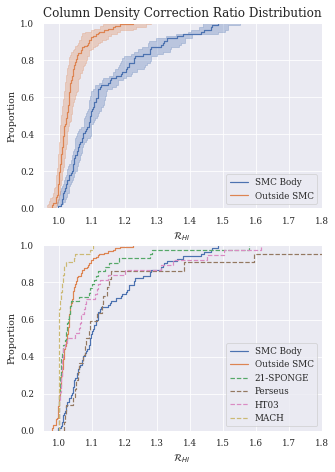

In [9]:
fig, axs = plt.subplots(2,1, figsize=(5,7.5))

rhi_smc = smc_hi_table['r_hi']
rhi_low_smc = smc_hi_table['r_hi'] - smc_hi_table['e_r_hi_low']
rhi_high_smc = smc_hi_table['r_hi'] + smc_hi_table['e_r_hi_high']

#ln_filter = (non_detect | detections) & (spectra_table['r_hi'] > 0) # Includes everything plotted in the Correction Ratio by Column Density plot
has_rhi_filter = spectra_table['r_hi'] > 0
rhi_all = spectra_table['r_hi'][has_rhi_filter]
rhi_low_all = spectra_table['r_hi'][has_rhi_filter] - spectra_table['e_r_hi_low'][has_rhi_filter]
rhi_high_all = spectra_table['r_hi'][has_rhi_filter] + spectra_table['e_r_hi_high'][has_rhi_filter]

field_filter = ~smc_filter & (spectra_table['r_hi'] > 0)
rhi_field = spectra_table['r_hi'][field_filter]
rhi_low_field = spectra_table['r_hi'][field_filter] - spectra_table['e_r_hi_low'][field_filter]
rhi_high_field = spectra_table['r_hi'][field_filter] + spectra_table['e_r_hi_high'][field_filter]



ax = axs[0]
ecdf = sns.ecdfplot(x=rhi_smc, complementary=False, ax=ax, legend=False, color='C0')
num = len(rhi_low_smc)
y = np.arange(num)/float(num)+ 1/float(num)
ax.fill_betweenx(y, np.sort(rhi_low_smc), np.sort(rhi_high_smc), color='C0', alpha=0.3, step='pre')

ecdf = sns.ecdfplot(x=rhi_field, complementary=False, ax=ax, legend=False, color='C1')
num = len(rhi_low_field)
y = np.arange(num)/float(num)+ 1/float(num)
ax.fill_betweenx(y, np.sort(rhi_low_field), np.sort(rhi_high_field), color='C1', alpha=0.3, step='pre')
ax.set_xlim(0.95,1.8)

ax.set_xlabel(r'$\mathcal{R}_{HI}$')
ax.set_title('Column Density Correction Ratio Distribution', size=12)

ax.legend(['SMC Body', 'Outside SMC'], loc='lower right')






ax = axs[1]

ecdf = sns.ecdfplot(x=rhi_smc, complementary=False, ax=ax, legend=False, color='C0', zorder=2)
ecdf = sns.ecdfplot(x=rhi_field, complementary=False, ax=ax, legend=False, color='C1', zorder=2)
colors = ['C2', 'C5', 'C6']
for idx, label in enumerate(('SPONGE', 'Perseus', 'HT03')):
    comp_filt = comparison_data['tags']==label
    rhi = comparison_data['rhi_abs'][comp_filt].astype('float64')
    sns.ecdfplot(x=rhi, ax=ax, legend=False, ls='--', color=colors[idx])
sns.ecdfplot(x=mach_data['rhi_abs'].astype('float64'), ax=ax, legend=False, ls='--', color='C8')
ax.set_xlim(0.95,1.8)
ax.set_xlabel(r'$\mathcal{R}_{HI}$')

ax.legend(['SMC Body', 'Outside SMC', '21-SPONGE', 'Perseus', 'HT03', 'MACH'])

plt.savefig('figures/r_hi_cdf_smc_comp.png', bbox_inches='tight', dpi=200)
plt.savefig('figures/r_hi_cdf_smc_comp.pdf', bbox_inches='tight')





### Mean Spin temperature

/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


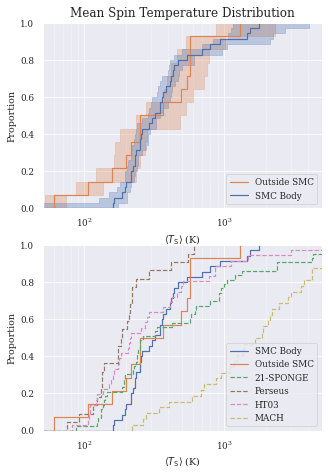

In [10]:
fig, axs = plt.subplots(2,1, figsize=(5,7.5))

pos_det = detections & (spectra_table['mean_ts'] > 0) & (spectra_table['min_opacity'] > 0)
smc_det = pos_det & (spectra_table['nh_uncorr'] >= 2e21)
non_smc_det = pos_det & (spectra_table['nh_uncorr'] < 2e21)

mean_ts_smc = spectra_table['mean_ts'][smc_det]
mean_ts_low_smc = np.array(spectra_table['mean_ts'][smc_det] - spectra_table['e_mean_ts_low'][smc_det])
mean_ts_high_smc = np.array(spectra_table['mean_ts'][smc_det] + spectra_table['e_mean_ts_high'][smc_det])

mean_ts_field = spectra_table['mean_ts'][non_smc_det]
mean_ts_low_field = np.array(spectra_table['mean_ts'][non_smc_det] - spectra_table['e_mean_ts_low'][non_smc_det])
mean_ts_high_field = np.array(spectra_table['mean_ts'][non_smc_det] + spectra_table['e_mean_ts_high'][non_smc_det])


ax = axs[0]

ecdf = sns.ecdfplot(x=mean_ts_field, complementary=False, ax=ax, legend=False, color='C1', log_scale=(True, False))
num = len(mean_ts_low_field)
y = np.append(0, np.arange(num)/float(num)+ 1/float(num))
low = np.append(np.min(mean_ts_low_field), np.sort(mean_ts_low_field))
high = np.append(np.min(mean_ts_high_field), np.sort(mean_ts_high_field))
ax.fill_betweenx(y, low, high, color='C1', alpha=0.3, step='pre')

ecdf = sns.ecdfplot(x=mean_ts_smc, complementary=False, ax=ax, legend=False, color='C0', log_scale=(True, False))
num = len(mean_ts_low_smc)
y = np.append(0, np.arange(num)/float(num)+ 1/float(num))
low = np.append(np.min(mean_ts_low_smc), np.sort(mean_ts_low_smc))
high = np.append(np.min(mean_ts_high_smc), np.sort(mean_ts_high_smc))
ax.fill_betweenx(y, low, high, color='C0', alpha=0.3, step='pre')

ax.set_xlim(50,5000)
#ax.set_xscale("log", base=10)

ax.grid(True, which="major", ls="-")
ax.grid(True, which="minor", ls=":")



ax.set_xlabel(r'$\langle T_{\rm S} \rangle$ (K)')
ax.set_title('Mean Spin Temperature Distribution', size=12)

ax.legend(['Outside SMC', 'SMC Body'], loc='lower right')


ax = axs[1]

ecdf = sns.ecdfplot(x=mean_ts_smc, complementary=False, ax=ax, legend=False, color='C0', zorder=2, log_scale=(True, False))
ecdf = sns.ecdfplot(x=mean_ts_field, complementary=False, ax=ax, legend=False, color='C1', zorder=2, log_scale=(True, False))
colors = ['C2', 'C5', 'C6']
for idx, label in enumerate(('SPONGE', 'Perseus', 'HT03')):
    comp_filt = comparison_data['tags']==label
    mean_ts = comparison_data['intts_abs'][comp_filt].astype('float64')
    sns.ecdfplot(x=mean_ts, ax=ax, legend=False, ls='--', color=colors[idx])
sns.ecdfplot(x=mach_data['intts_abs'].astype('float64'), ax=ax, legend=False, ls='--', color='C8', log_scale=(True, False))
ax.set_xlim(50,5000)
ax.set_xlabel(r'$\langle T_{\rm S} \rangle$ (K)')
#ax.set_xscale("log", base=10)

ax.grid(True, which="major", ls="-")
ax.grid(True, which="minor", ls=":")


ax.legend(['SMC Body', 'Outside SMC', '21-SPONGE', 'Perseus', 'HT03', 'MACH'])


plt.savefig('figures/mean_ts_cdf_smc_comp.png', bbox_inches='tight', dpi=200)
plt.savefig('figures/mean_ts_cdf_smc_comp.pdf', bbox_inches='tight')






In [62]:
print ("Squared weights")
detections = spectra_table['has_other_abs']

pos_det = detections & (spectra_table['mean_ts'] > 0)

weights = 1/(np.max([spectra_table['e_mean_ts_low'],spectra_table['e_mean_ts_high']], axis=0)**2)

all_det_mean_ts = np.average(spectra_table['mean_ts'][pos_det], weights=weights[pos_det])
e_all_det_mean_ts_low = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_low'][pos_det]**2))
e_all_det_mean_ts_high = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_high'][pos_det]**2))

print ("all detections <T_S> = {:.1f} +{:.1f} -{:.1f}".format(all_det_mean_ts, e_all_det_mean_ts_high, e_all_det_mean_ts_low))

smc_det = pos_det & (spectra_table['nh_uncorr'] >= 2e21)
smc_det_mean_ts = np.average(spectra_table['mean_ts'][smc_det], weights=weights[smc_det])
e_smc_det_mean_ts_low = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_low'][smc_det]**2))
e_smc_det_mean_ts_high = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_high'][smc_det]**2))

print ("smc detections <T_S> = {:.1f} +{:.1f} -{:.1f}".format(smc_det_mean_ts, e_smc_det_mean_ts_high, e_smc_det_mean_ts_low))

non_smc_det = pos_det & (spectra_table['nh_uncorr'] < 2e21)
non_smc_det_mean_ts = np.average(spectra_table['mean_ts'][non_smc_det], weights=weights[non_smc_det])
e_non_smc_det_mean_ts_low = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_low'][non_smc_det]**2))
e_non_smc_det_mean_ts_high = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_high'][non_smc_det]**2))

print ("non-smc detections <T_S> = {:.1f} +{:.1f} -{:.1f}\n".format(non_smc_det_mean_ts, e_non_smc_det_mean_ts_high, e_non_smc_det_mean_ts_low))



for idx, label in enumerate(('SPONGE', 'Perseus', 'HT03')):
    comp_filt = comparison_data['tags']==label
    err = comparison_data['intts_abs_err'][comp_filt].astype('float64')
    weights = 1/(err**2)
    temps = comparison_data['intts_abs'][comp_filt].astype('float64')
    all_mean_ts = np.average(temps, weights=weights)
    e_all_mean_ts = np.sqrt(1/np.sum(1/err**2))
    print ("{} comparison <T_S> = {:.1f} +-{:.1f}".format(label, all_mean_ts, e_all_mean_ts))

label = 'MACH'
err = mach_data['intts_abs_err'].astype('float64')
weights = 1/(err**2)
temps = mach_data['intts_abs'].astype('float64')
all_mean_ts = np.average(temps, weights=weights)
e_all_mean_ts = np.sqrt(1/np.sum(1/err**2))
print ("{} comparison <T_S> = {:.1f} +-{:.1f}".format(label, all_mean_ts, e_all_mean_ts))



Squared weights
all detections <T_S> = 253.6 +2.2 -1.9
smc detections <T_S> = 258.6 +2.3 -2.0
non-smc detections <T_S> = 159.4 +9.8 -7.0

SPONGE comparison <T_S> = 188.8 +-0.0
Perseus comparison <T_S> = 100.7 +-0.1
HT03 comparison <T_S> = 116.2 +-0.2
MACH comparison <T_S> = 268.7 +-34.4


In [49]:
print ("Linear weights")
detections = spectra_table['has_other_abs']

pos_det = detections & (spectra_table['mean_ts'] > 0)

weights = 1/(np.max([spectra_table['e_mean_ts_low'],spectra_table['e_mean_ts_high']], axis=0))

all_det_mean_ts = np.average(spectra_table['mean_ts'][pos_det], weights=weights[pos_det])
e_all_det_mean_ts_low = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_low'][pos_det]))
e_all_det_mean_ts_high = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_high'][pos_det]))

print ("all detections <T_S> = {:.1f} +{:.1f} -{:.1f}".format(all_det_mean_ts, e_all_det_mean_ts_high, e_all_det_mean_ts_low))

smc_det = pos_det & (spectra_table['nh_uncorr'] >= 2e21)
smc_det_mean_ts = np.average(spectra_table['mean_ts'][smc_det], weights=weights[smc_det])
e_smc_det_mean_ts_low = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_low'][smc_det]))
e_smc_det_mean_ts_high = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_high'][smc_det]))

print ("smc detections <T_S> = {:.1f} +{:.1f} -{:.1f}".format(smc_det_mean_ts, e_smc_det_mean_ts_high, e_smc_det_mean_ts_low))

non_smc_det = pos_det & (spectra_table['nh_uncorr'] < 2e21)
non_smc_det_mean_ts = np.average(spectra_table['mean_ts'][non_smc_det], weights=weights[non_smc_det])
e_non_smc_det_mean_ts_low = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_low'][non_smc_det]))
e_non_smc_det_mean_ts_high = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_high'][non_smc_det]))

print ("non-smc detections <T_S> = {:.1f} +{:.1f} -{:.1f}\n".format(non_smc_det_mean_ts, e_non_smc_det_mean_ts_high, e_non_smc_det_mean_ts_low))



for idx, label in enumerate(('SPONGE', 'Perseus', 'HT03')):
    comp_filt = comparison_data['tags']==label
    err = comparison_data['intts_abs_err'][comp_filt].astype('float64')
    weights = 1/(err)
    temps = comparison_data['intts_abs'][comp_filt].astype('float64')
    all_mean_ts = np.average(temps, weights=weights)
    e_all_mean_ts = np.sqrt(1/np.sum(1/err))
    print ("{} comparison <T_S> = {:.1f} +-{:.1f}".format(label, all_mean_ts, e_all_mean_ts))

label = 'MACH'
err = mach_data['intts_abs_err'].astype('float64')
weights = 1/(err)
temps = mach_data['intts_abs'].astype('float64')
all_mean_ts = np.average(temps, weights=weights)
e_all_mean_ts = np.sqrt(1/np.sum(1/err))
print ("{} comparison <T_S> = {:.1f} +-{:.1f}".format(label, all_mean_ts, e_all_mean_ts))




Linear weights
all detections <T_S> = 269.6 +0.6 -0.6
smc detections <T_S> = 274.9 +0.7 -0.6
non-smc detections <T_S> = 224.6 +2.0 -1.6

SPONGE comparison <T_S> = 187.1 +-0.1
Perseus comparison <T_S> = 130.0 +-0.1
HT03 comparison <T_S> = 135.2 +-0.2
MACH comparison <T_S> = 444.6 +-3.0


### Cold Gas Fraction

/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_83160/3461010965.py:54: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0, 0.5)


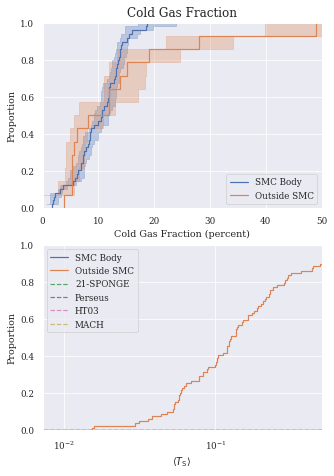

In [57]:
fig, axs = plt.subplots(2,1, figsize=(5,7.5))

t_cool = 30 # K
fraction_cool = (t_cool/spectra_table['mean_ts'])*100
fraction_cool_high = (t_cool/(spectra_table['mean_ts']-spectra_table['e_mean_ts_low']))*100
fraction_cool_low = (t_cool/(spectra_table['mean_ts']+spectra_table['e_mean_ts_high']))*100

pos_det = detections & (spectra_table['mean_ts'] > 0)

f_cool_smc = fraction_cool[pos_det & smc_filter]
f_cool_high_smc = fraction_cool_high[pos_det & smc_filter]
f_cool_low_smc = fraction_cool_low[pos_det & smc_filter]

f_cool_field = fraction_cool[pos_det & ~smc_filter]
f_cool_high_field = fraction_cool_high[pos_det & ~smc_filter]
f_cool_low_field = fraction_cool_low[pos_det & ~smc_filter]



ax = axs[0]
ecdf = sns.ecdfplot(x=f_cool_smc, complementary=False, ax=ax, legend=False, color='C0')
num = len(f_cool_low_smc)
y = np.arange(num)/float(num)+ 1/float(num)
ax.fill_betweenx(y, np.sort(f_cool_low_smc), np.sort(f_cool_high_smc), color='C0', alpha=0.3, step='pre')

ecdf = sns.ecdfplot(x=f_cool_field, complementary=False, ax=ax, legend=False, color='C1')
num = len(f_cool_low_field)
y = np.arange(num)/float(num)+ 1/float(num)
ax.fill_betweenx(y, np.sort(f_cool_low_field), np.sort(f_cool_high_field), color='C1', alpha=0.3, step='pre')
ax.set_xlim(0, 50)
#ax.set_xscale("log", base=10)


ax.set_xlabel(r'Cold Gas Fraction (percent)')
ax.set_title('Cold Gas Fraction', size=12)

ax.legend(['SMC Body', 'Outside SMC'], loc='lower right')






ax = axs[1]

ecdf = sns.ecdfplot(x=rhi_smc, complementary=False, ax=ax, legend=False, color='C0', zorder=2, log_scale=(True, False))
ecdf = sns.ecdfplot(x=rhi_field, complementary=False, ax=ax, legend=False, color='C1', zorder=2, log_scale=(True, False))
colors = ['C2', 'C5', 'C6']
for idx, label in enumerate(('SPONGE', 'Perseus', 'HT03')):
    comp_filt = comparison_data['tags']==label
    rhi = comparison_data['intts_abs'][comp_filt].astype('float64')
    sns.ecdfplot(x=rhi, ax=ax, legend=False, ls='--', color=colors[idx])
sns.ecdfplot(x=mach_data['intts_abs'].astype('float64'), ax=ax, legend=False, ls='--', color='C8', log_scale=(True, False))
ax.set_xlim(0, 0.5)
ax.set_xlabel(r'$\langle T_{\rm S} \rangle$')
#ax.set_xscale("log", base=10)

ax.legend(['SMC Body', 'Outside SMC', '21-SPONGE', 'Perseus', 'HT03', 'MACH'])

#plt.savefig('figures/r_hi_cdf_smc_comp.png', bbox_inches='tight', dpi=200)
#plt.savefig('figures/r_hi_cdf_smc_comp.pdf', bbox_inches='tight')







In [23]:
smc_hi_table.columns

<TableColumns names=('id','comp_name','ra','dec','glon','glat','rating','flux_peak','flux_int','mean_cont','sd_cont','opacity_range','max_s_max_n','max_noise','num_chan_noise','min_opacity','vel_min_opacity','peak_tau','e_peak_tau','has_mw_abs','has_other_abs','semi_maj_axis','semi_min_axis','pa','nh_gass','noise_flag','beam_power','nh_uncorr','e_nh_uncorr_high','e_nh_uncorr_low','nh_corr','e_nh_corr_high','e_nh_corr_low','r_hi','e_r_hi_high','e_r_hi_low','f_int','mean_ts','e_mean_ts_high','e_mean_ts_low','ew','e_ew_high','e_ew_low','num_chan')>